# !!! Change the Filename accordingly !!!

In [13]:
figure_name = 'figures/fig_3_parameter'

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d

from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

drawing_size = 12


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.weight']= 'normal'
mpl.rcParams['font.family'] =  ['Arial']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'


mpl.rcParams['figure.figsize'] = [8.0, 5.0]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300


# print(mpl.rcParams.keys())


In [20]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 8.0 # -> 80ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 3.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 4.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

In [21]:
############################################################
#                       Functions                          #
############################################################




#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.20):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.minimum(np.maximum(q_pc,0),1)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # default gaba inhibiton
#     gaba_inh -= 0.01
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel
    excitatory_in = convolve1d(s_sbc,weights=ee_kernel,axis=0,mode='reflect')*(1-gaba_exc)
    # calculate inhibitor input, which comes from the q_pc folded by the E-I kernel
    inhibitory_in = convolve1d(g_q_out(q_pc),weights=ei_kernel,axis=0,mode='reflect')*(1-gaba_inh)     
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = convolve1d(s_gbc,weights=ie_kernel,axis=0,mode='reflect')
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = convolve1d(g_q_out(q_pc_all),weights=ii_kernel,axis=0,mode='reflect')     
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q

# Divisive Inhibition (Kappa)

In [22]:
############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))


kappas_r = np.arange(0,16,2)
gamma_r = 3.0

############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))

# Define input signal in a plausible way (gaussian input signal over frequency bands?)
# Define input signal in a plausible way (gaussian input signal over frequency bands?)
sigma = 1.0

### MNTB inhibitory input (contra-lateral) ###
gbc_center_frequencyBand =2
gbc_input_strength = 1.0

# build ramps
time_window = 400 # that equals a step of 5dB
for i in range(0,len(t)-time_window,time_window):
    s_gbc_all[i:i+time_window,:] = (i)/(len(t)-time_window) * gbc_input_strength



# LSO direct excitatory input (ipsi-lateral)
sbc_center_frequencyBand = 2
sbc_input_strength = 1.0

# build ramps
for i in range(0,len(t)-time_window,time_window):
    s_sbc_all[i:i+time_window,:] = (len(t)-time_window-i)/(len(t)-time_window) * sbc_input_strength

    

gauss_mask = gauss(np.linspace(-50,50,5000),0,1)
s_gbc_all = convolve1d(s_gbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='reflect')
gauss_mask = gauss(np.linspace(-50,50,5000),0,1)
s_sbc_all = convolve1d(s_sbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='reflect')




# correct for border effect of convolve
s_gbc_all[-250:,:] = np.max(s_gbc_all[-250:])
s_sbc_all[:250,:] = np.max(s_sbc_all[:250])

sigma =0.5
ee_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.6
ei_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.1
ie_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 1.0
ii_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)

ee_kernel /= np.max(ee_kernel)
ei_kernel /= np.max(ie_kernel)
ie_kernel /= np.max(ie_kernel)
ii_kernel /= np.max(ie_kernel)
ii_kernel = np.zeros(freq_bands)

q_all = np.zeros((len(kappas_r),len(t),freq_bands))
r_all = np.zeros((len(kappas_r),len(t),freq_bands))
############################################################
#                      Simulation                          #
############################################################
for k in range(len(kappas_r)):
    kappa_r = kappas_r[k]
    for i in range(0, len(t)-1):
        r_all[k,i+1,:] = r_all[k,i,:] +  dt * ode_r_bpc(r_all[k,i,:],s_sbc_all[i],ee_kernel,g_q_out(q_all[k,i,:]),ei_kernel)       
        q_all[k,i+1,:] = q_all[k,i,:] +  dt * ode_q_pc(q_all[k,i,:],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)


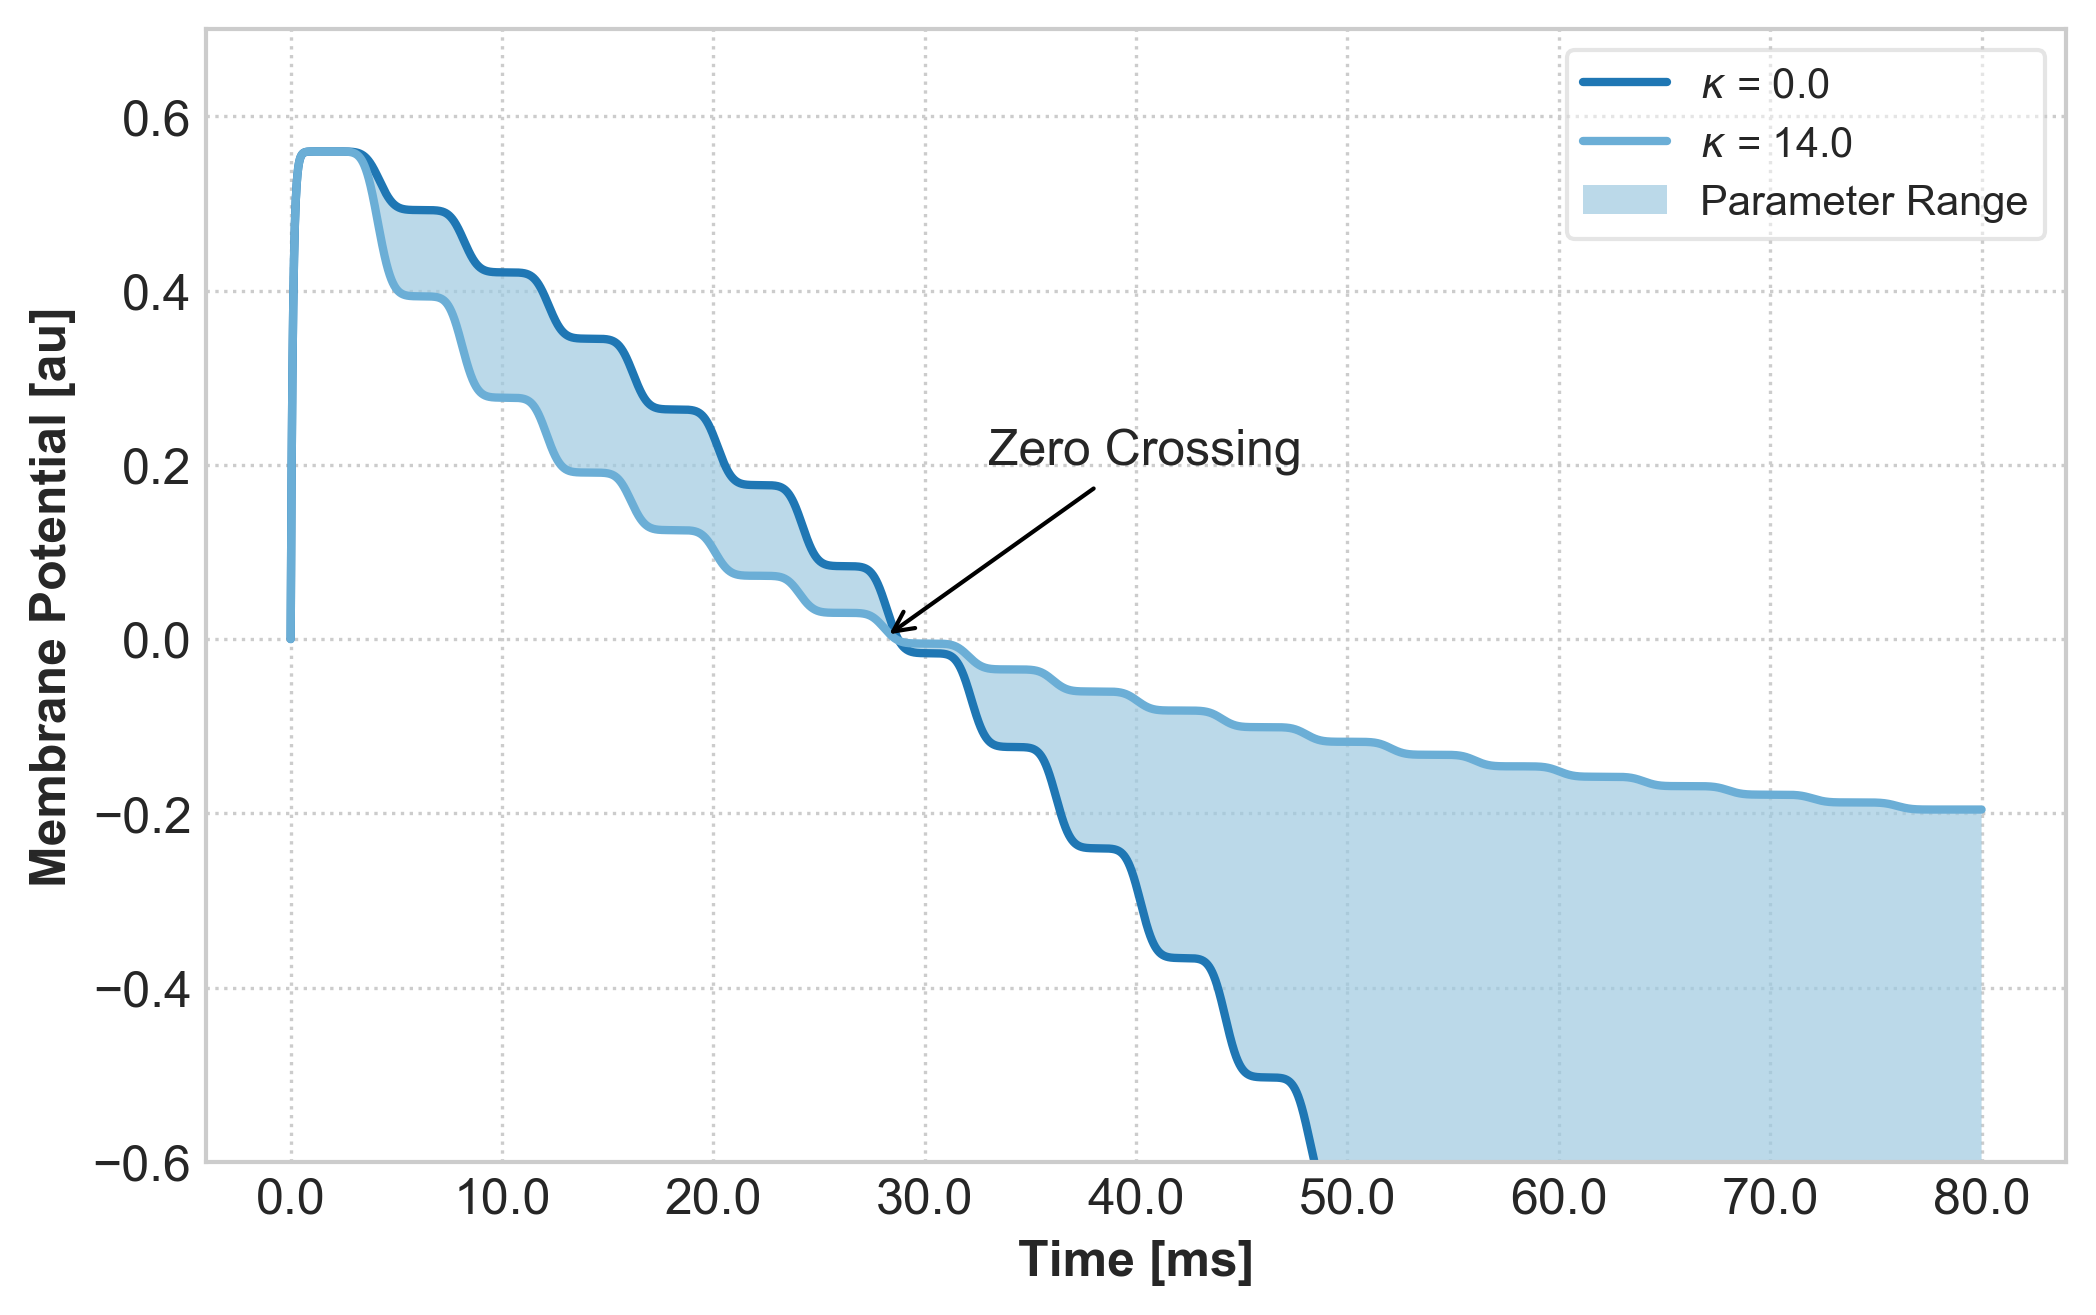

In [25]:
############################################################
#                       Plotting                           #
############################################################
probing_times = np.arange(280,len(t),time_window)

fig = plt.figure()
ax1 = fig.add_subplot(111)

tmp = r_all[0,:,sbc_center_frequencyBand]
stri = r'$\kappa$ = {0:.1f}'.format(kappas_r[0])
ax1.plot(t,tmp,linestyle='-',label=stri)

tmp2 = r_all[-1,:,sbc_center_frequencyBand]
stri = r'$\kappa$ = {0:.1f}'.format(kappas_r[-1])
ax1.plot(t,tmp2,linestyle='-',color='#6baed6',label=stri)

ax1.fill_between(t,tmp, tmp2, facecolor='#9ecae1', alpha=0.7,label='Parameter Range')

ax1.annotate("Zero Crossing", xy=(2.8, 0), xytext=(3.3, 0.2),arrowprops=dict(arrowstyle="->",linewidth=1))
    

plt.ylim([-0.6,0.7])
    
# plt.title('Membrane Potential')
plt.xlabel('Time [ms]')
ax1.set_xticklabels(ax1.get_xticks()*10)
plt.ylabel('Membrane Potential [au]')

lgd = plt.legend()

plt.savefig(figure_name + 'membrane_kappa.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'membrane_kappa.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'membrane_kappa.tiff', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()









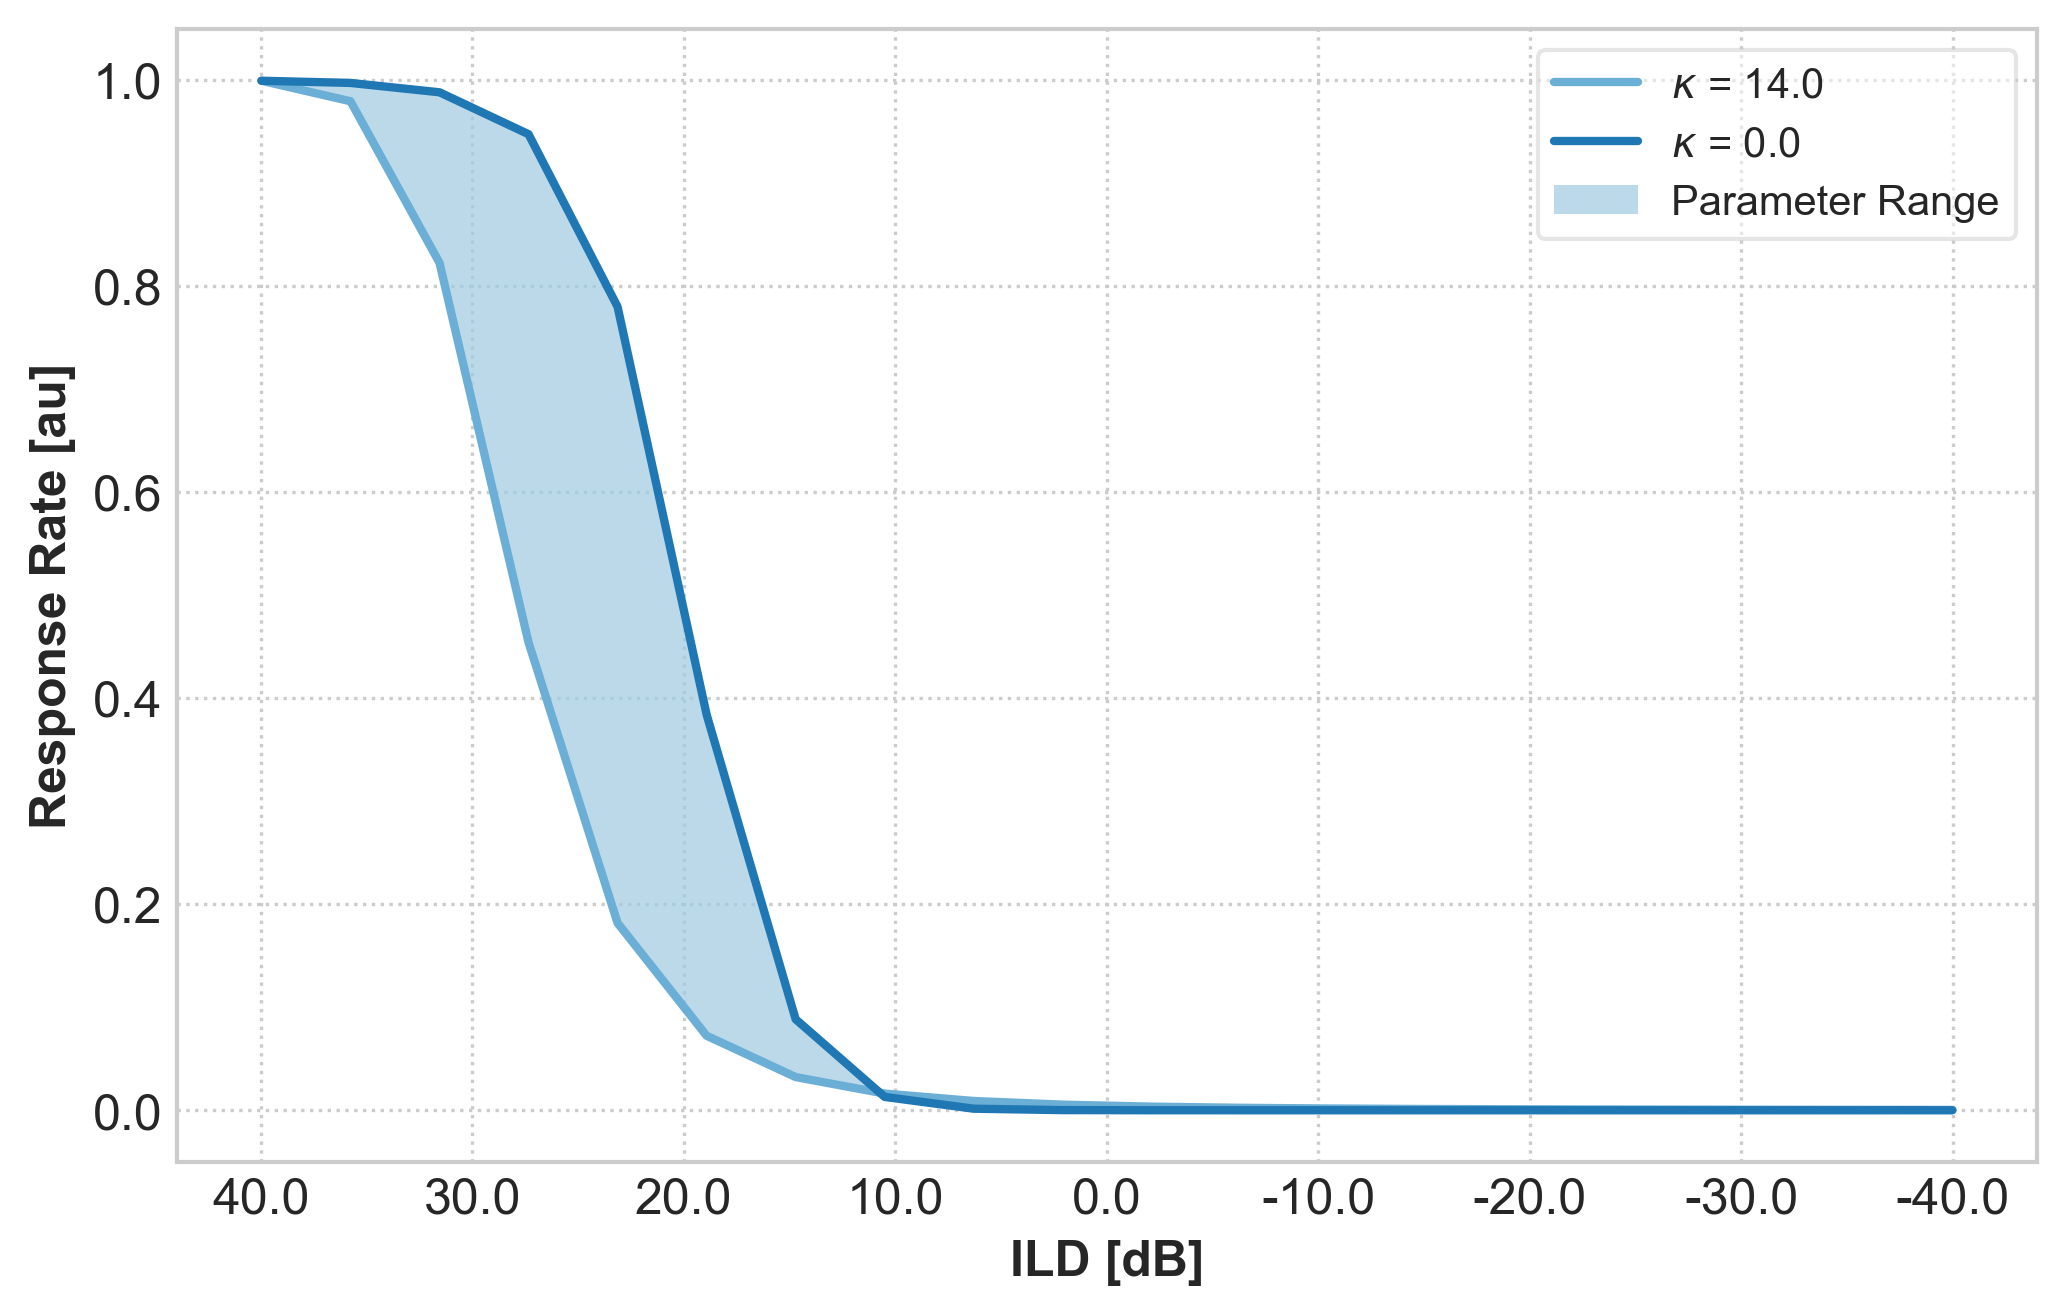

In [24]:
fig = plt.figure()

ax1 = fig.add_subplot(111)
# plt.title('LSO Neuron Output')


    
diff_input =  s_gbc_all-s_sbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]


# fill_range = range(50,tmp.shape[0]-2050)

tmp2 = g_r_out(r_all[-1,:,sbc_center_frequencyBand])
stri = r'$\kappa$ = {0:.1f}'.format(kappas_r[-1])
ax1.plot(-diff_input[probing_times],tmp2[probing_times],linestyle='-',color='#6baed6',label=stri)

# fill_range = range(50,tmp.shape[0])

tmp = g_r_out(r_all[0,:,sbc_center_frequencyBand])
stri = r'$\kappa$ = {0:.1f}'.format(kappas_r[0])
ax1.plot(-diff_input[probing_times],tmp[probing_times],linestyle='-',label=stri)



ax1.fill_between(-diff_input[probing_times],tmp[probing_times], tmp2[probing_times], facecolor='#9ecae1', alpha=0.7,label='Parameter Range')


    

l = [0]
l.extend(np.linspace(-40,40,len(ax1.get_xticklabels())-2))
ax1.set_xticklabels(l)
ax1.invert_xaxis()
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
lgd = plt.legend()


plt.savefig(figure_name + 'response_kappa.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'response_kappa.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'response_kappa.tiff', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Subtractive Inhibition (Gamma)

In [26]:
############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))
############################################################



gammas_r = np.arange(0,4.0,0.5)
kappa_r = 4.0

############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))

# Define input signal in a plausible way (gaussian input signal over frequency bands?)
# Define input signal in a plausible way (gaussian input signal over frequency bands?)
sigma = 1.0

### MNTB inhibitory input (contra-lateral) ###
gbc_center_frequencyBand =2
gbc_input_strength = 1.0

# build ramps
time_window = 400 # that equals a step of 5dB
for i in range(0,len(t)-time_window,time_window):
    s_gbc_all[i:i+time_window,:] = (i)/(len(t)-time_window) * gbc_input_strength



# LSO direct excitatory input (ipsi-lateral)
sbc_center_frequencyBand = 2
sbc_input_strength = 1.0

# build ramps
for i in range(0,len(t)-time_window,time_window):
    s_sbc_all[i:i+time_window,:] = (len(t)-time_window-i)/(len(t)-time_window) * sbc_input_strength

    

gauss_mask = gauss(np.linspace(-50,50,5000),0,1)
s_gbc_all = convolve1d(s_gbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='reflect')
gauss_mask = gauss(np.linspace(-50,50,5000),0,1)
s_sbc_all = convolve1d(s_sbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='reflect')




# correct for border effect of convolve
s_gbc_all[-250:,:] = np.max(s_gbc_all[-250:])
s_sbc_all[:250,:] = np.max(s_sbc_all[:250])


sigma =0.5
ee_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.6
ei_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.1
ie_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 1.0
ii_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)

ee_kernel /= np.max(ee_kernel)
ei_kernel /= np.max(ie_kernel)
ie_kernel /= np.max(ie_kernel)
ii_kernel /= np.max(ie_kernel)
ii_kernel = np.zeros(freq_bands)

q_all = np.zeros((len(gammas_r),len(t),freq_bands))
r_all = np.zeros((len(gammas_r),len(t),freq_bands))
############################################################
#                      Simulation                          #
############################################################
for k in range(len(gammas_r)):
    gamma_r = gammas_r[k]
    for i in range(0, len(t)-1):

        r_all[k,i+1,:] = r_all[k,i,:] +  dt * ode_r_bpc(r_all[k,i,:],s_sbc_all[i],ee_kernel,g_q_out(q_all[k,i,:]),ei_kernel)       

        q_all[k,i+1,:] = q_all[k,i,:] +  dt * ode_q_pc(q_all[k,i,:],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)









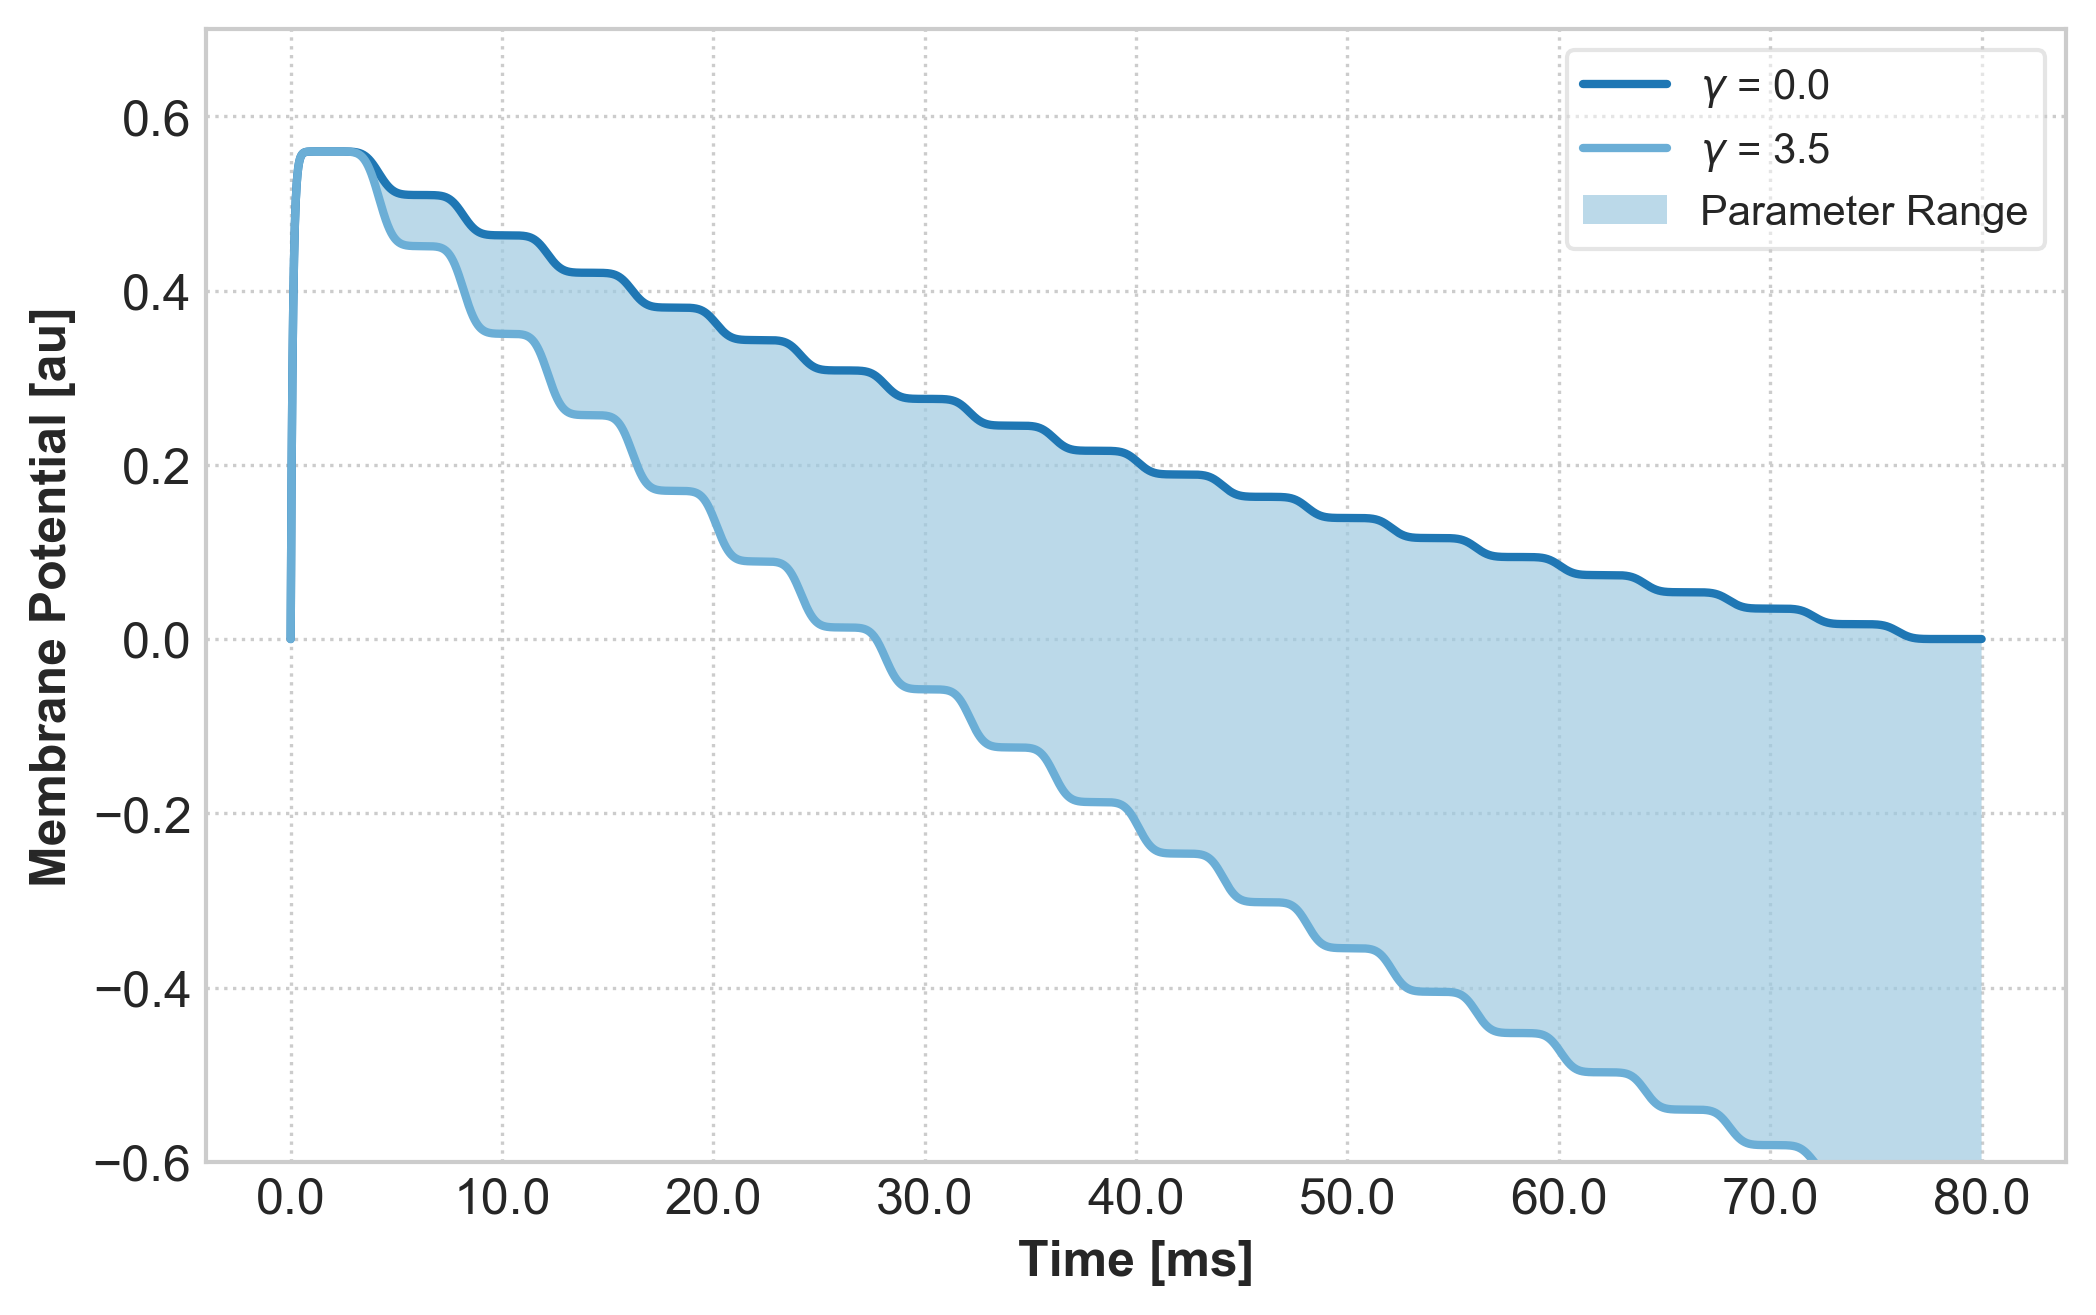

In [31]:
############################################################
#                       Plotting                           #
############################################################
probing_times = np.arange(280,len(t),time_window)

fig = plt.figure()
ax1 = fig.add_subplot(111)

tmp = r_all[0,:,sbc_center_frequencyBand]
stri = r'$\gamma$ = {0:.1f}'.format(gammas_r[0])
ax1.plot(t,tmp,linestyle='-',label=stri)

tmp2 = r_all[-1,:,sbc_center_frequencyBand]
stri = r'$\gamma$ = {0:.1f}'.format(gammas_r[-1])
ax1.plot(t,tmp2,linestyle='-',color='#6baed6',label=stri)

ax1.fill_between(t,tmp, tmp2, facecolor='#9ecae1', alpha=0.7,label='Parameter Range')


plt.ylim([-0.6,0.7])
    
# plt.title('LSO Neuron Membrane')
plt.xlabel('Time [ms]')
ax1.set_xticklabels(ax1.get_xticks()*10)

plt.ylabel('Membrane Potential [au]')

lgd = plt.legend()

plt.savefig(figure_name + 'membrane_gamma.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'membrane_gamma.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'membrane_gamma.tiff', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()









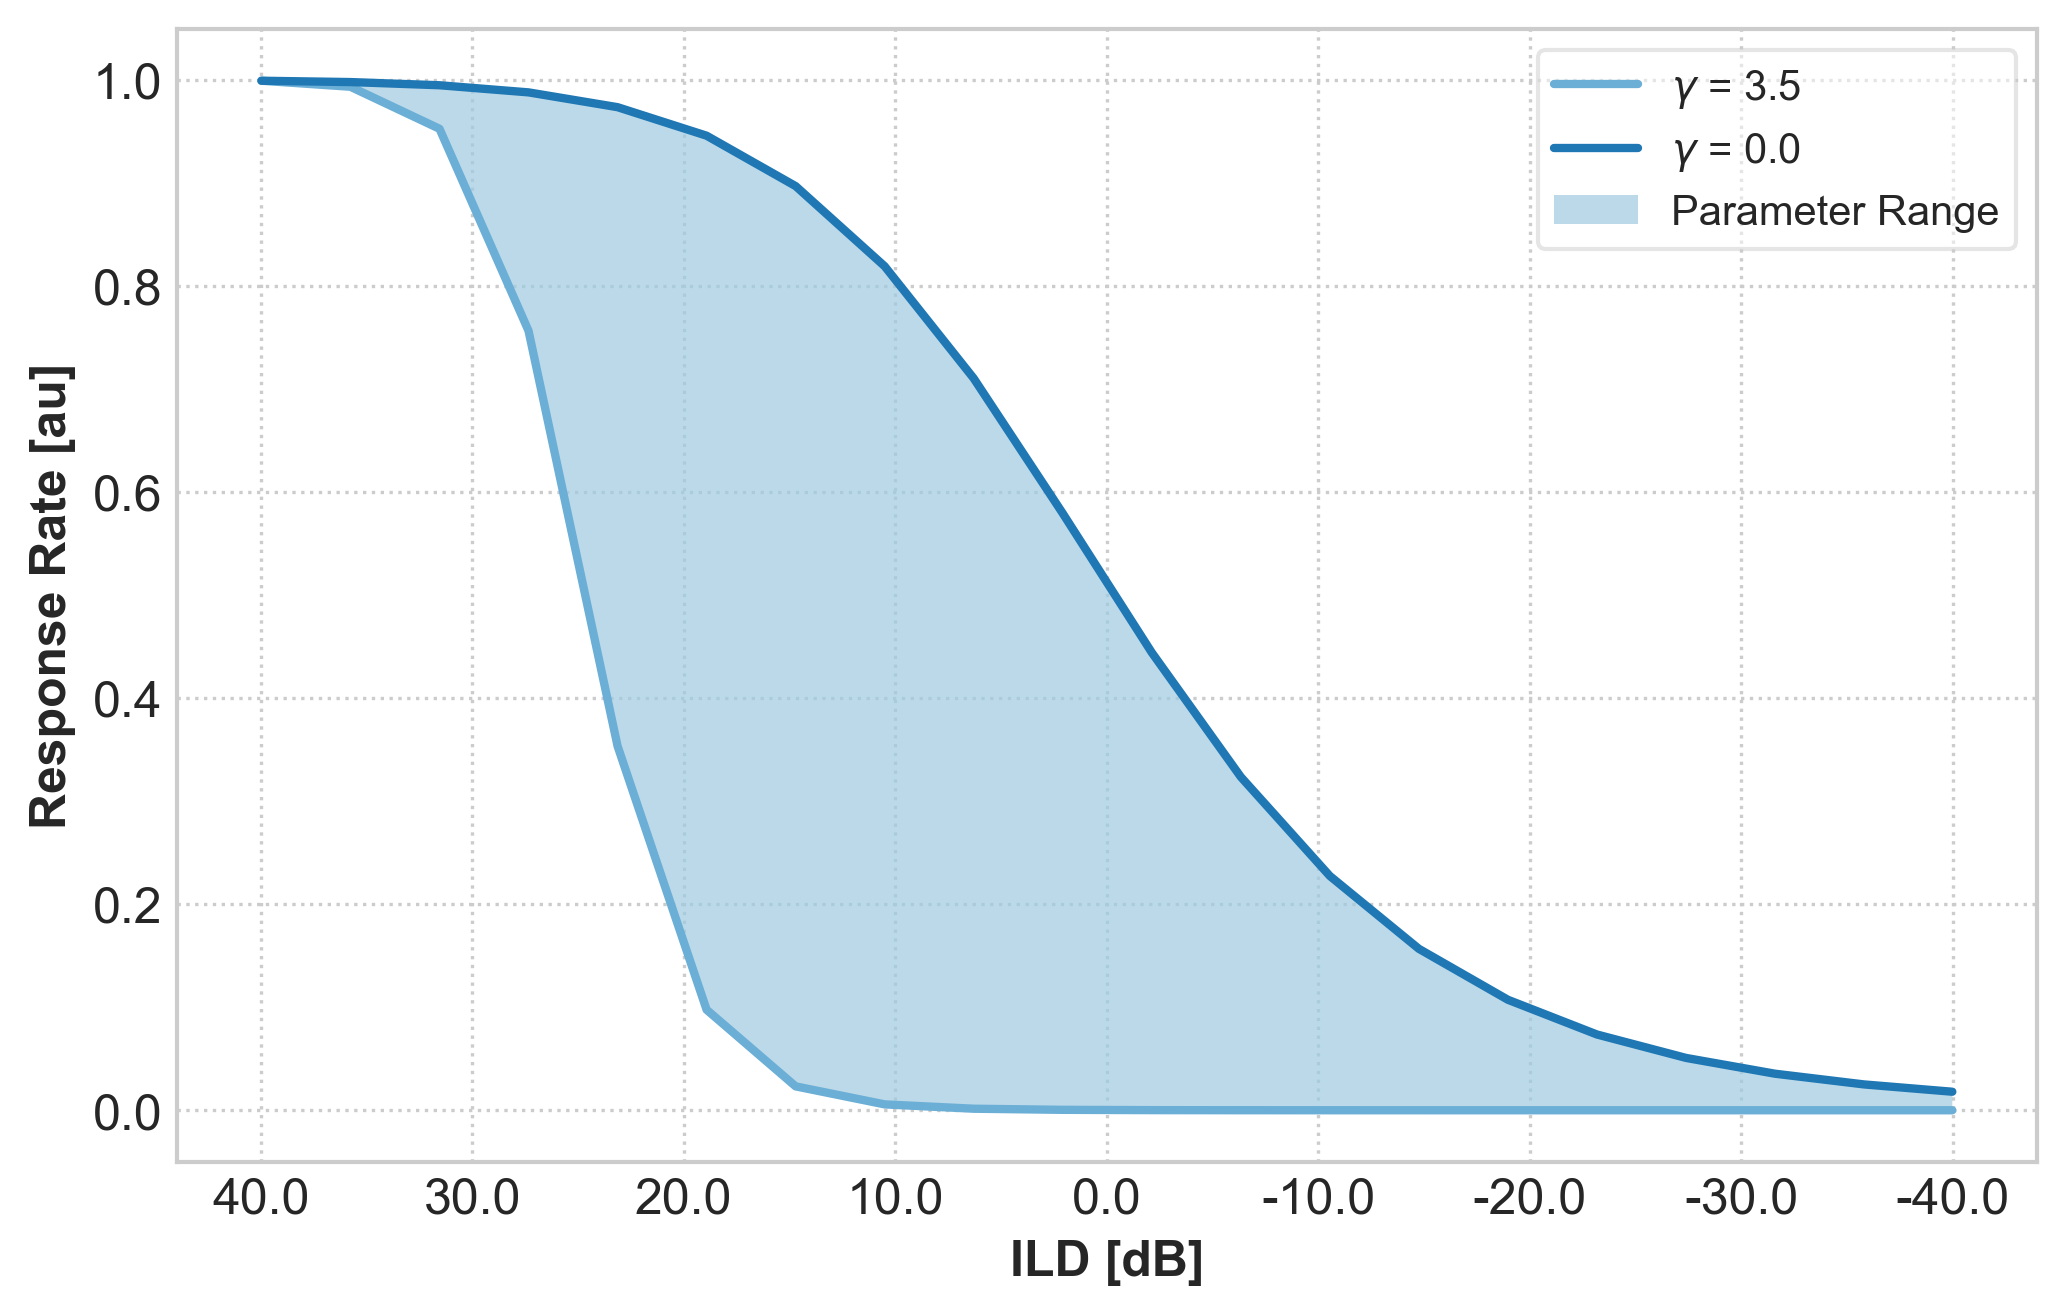

In [28]:
fig = plt.figure()

ax1 = fig.add_subplot(111)
# plt.title('LSO Neuron Response Rate')


    
diff_input =  s_gbc_all-s_sbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]


# fill_range = range(50,tmp.shape[0]-2050)

tmp2 = g_r_out(r_all[-1,:,sbc_center_frequencyBand])
stri = r'$\gamma$ = {0:.1f}'.format(gammas_r[-1])
ax1.plot(-diff_input[probing_times],tmp2[probing_times],linestyle='-',color='#6baed6',label=stri)

# fill_range = range(50,tmp.shape[0])

tmp = g_r_out(r_all[0,:,sbc_center_frequencyBand])
stri = r'$\gamma$ = {0:.1f}'.format(gammas_r[0])
ax1.plot(-diff_input[probing_times],tmp[probing_times],linestyle='-',label=stri)



ax1.fill_between(-diff_input[probing_times],tmp[probing_times], tmp2[probing_times], facecolor='#9ecae1', alpha=0.7,label='Parameter Range')

    

l = [0]
l.extend(np.linspace(-40,40,len(ax1.get_xticklabels())-2))
ax1.set_xticklabels(l)
ax1.invert_xaxis()
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
lgd = plt.legend()


plt.savefig(figure_name + 'response_gamma.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'response_gamma.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'response_gamma.tiff', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [29]:
import dill
dill.dump_session('fig_3_0_parameters')